In [22]:
%matplotlib inline
import matplotlib
import sys
from matplotlib import pyplot as plt
from __future__ import print_function
import bornagain as ba
from bornagain import deg, angstrom, nm


def plot_intensity_data(result):
    """
    Plots intensity map.
    """

    zmin, zmax = 1.0, result.getMaximum()
    if zmin >= zmax:
        zmax = 1.0
        zmin = 1e-6*zmax

    im = plt.imshow(result.getArray(), norm=matplotlib.colors.LogNorm(zmin, zmax),
            extent=[result.getXmin()/deg, result.getXmax()/deg,
                    result.getYmin()/deg, result.getYmax()/deg],
        aspect='auto',
    )
    cb = plt.colorbar(im)
    cb.set_label(r'Intensity (arb. u.)', size=16)
    plt.xlabel(r'$\phi_f (^{\circ})$', fontsize=16)
    plt.ylabel(r'$\alpha_f (^{\circ})$', fontsize=16)
    plt.show()


In [23]:
"""
This example shows how to create a sample with fixed parameters, and then change
these parameters on the fly during runtime.
"""


def get_sample():
    """
    Returns a sample with uncorrelated cylinders and prisms on a substrate.
    Parameter set is fixed.
    """
    # defining materials
    m_air = ba.HomogeneousMaterial("Air", 0.0, 0.0)
    m_substrate = ba.HomogeneousMaterial("Substrate", 6e-6, 2e-8)
    m_particle = ba.HomogeneousMaterial("Particle", 6e-4, 2e-8)

    # collection of particles
    cylinder_ff = ba.FormFactorCylinder(5*nm, 5*nm)
    cylinder = ba.Particle(m_particle, cylinder_ff)
    prism_ff = ba.FormFactorPrism3(5*nm, 5*nm)
    prism = ba.Particle(m_particle, prism_ff)
    particle_layout = ba.ParticleLayout()
    particle_layout.addParticle(cylinder, 0.5)
    particle_layout.addParticle(prism, 0.5)

    # interference = ba.InterferenceFunctionRadialParaCrystal(20.0*nm, 1e3*nm)
    # pdf = ba.FTDistribution1DGauss(7 * nm)
    # interference.setProbabilityDistribution(pdf)
    # particle_layout.addInterferenceFunction(interference)

    # air layer with particles and substrate form multi layer
    air_layer = ba.Layer(m_air)
    air_layer.addLayout(particle_layout)
    substrate_layer = ba.Layer(m_substrate, 0)
    multi_layer = ba.MultiLayer()
    multi_layer.addLayer(air_layer)
    multi_layer.addLayer(substrate_layer)
    return multi_layer


def get_simulation():
    """
    Create and return GISAXS simulation with beam and detector defined
    """
    simulation = ba.GISASSimulation()
    simulation.setDetectorParameters(100, -1.0*deg, 1.0*deg,
                                     100, 0.0*deg, 2.0*deg)
    simulation.setBeamParameters(1.0*angstrom, 0.2*deg, 0.0*deg)
    return simulation


def run_simulation1():
    """
    Runs simulations with default parameters (i.e. parameters used during simulation construction).
    """

    sample = get_sample()
    print("The tree structure of the sample")
    print(sample.to_str())

    print("The sample contains following parameters ('name':value)")
    sample.printParameters()

    simulation = get_simulation()
    simulation.setSample(sample)

    print("The simulation contains following parameters ('name':value)")
    simulation.printParameters()

    simulation.runSimulation()
    return simulation.getIntensityData()


The tree structure of the sample
--------------------------------------------------------------------------------
 MultiLayer POOL_1('CrossCorrelationLength':0 )
.... Layer Air (1,0) POOL_1('Thickness':0 )
........ ParticleLayout POOL_0
............ Particle Particle (0.9994,2e-08)
................ Cylinder POOL_2('Radius':5 'Height':5 )
............ Particle Particle (0.9994,2e-08)
................ Prism3 POOL_2('BaseEdge':5 'Height':5 )
.... LayerInterface POOL_0
.... Layer Substrate (0.999994,2e-08) POOL_1('Thickness':0 )

The sample contains following parameters ('name':value)
The simulation contains following parameters ('name':value)


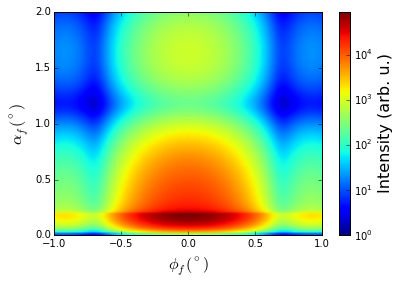

In [24]:
result = run_simulation1()
plot_intensity_data(result)


In [25]:
def run_simulation2():
    """
    Constructs simulation, changes one sample parameter using exact parameter name,
    runs simulation.
    """

    sample = get_sample()
    simulation = get_simulation()
    simulation.setSample(sample)

    print("The simulation contains following parameters ('name':value)")
    simulation.printParameters()

    # one sample parameter (cylinder height) is changed using exact parameter name
    simulation.setParameterValue(
        "/GISASSimulation/MultiLayer/Layer0/ParticleLayout/Particle0/Cylinder/Height", 10.0*nm)

    print("Now current parameters are ('name':value)")
    simulation.printParameters()

    simulation.runSimulation()
    return simulation.getIntensityData()


The simulation contains following parameters ('name':value)
Now current parameters are ('name':value)


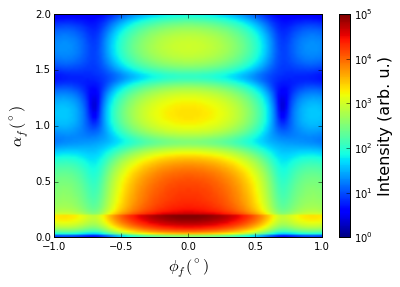

In [26]:
result = run_simulation2()
plot_intensity_data(result)


In [27]:
def run_simulation3():
    """
    Constructs simulation, changes few sample parameters using wildcards
    runs simulation.
    """

    sample = get_sample()
    simulation = get_simulation()
    simulation.setSample(sample)

    print("The simulation contains following parameters ('name':value)")
    simulation.printParameters()

    # all parameters matching criteria will be changed (cylinder height in this case)
    simulation.setParameterValue("*/Cylinder/Height", 100.0*nm)
    # all parameters matching criteria will be changed (Prism's radius and height in this case)
    simulation.setParameterValue("*/Prism3/*", 10.0*nm)

    print("Now current parameters are ('name':value)")
    simulation.printParameters()

    simulation.runSimulation()
    return simulation.getIntensityData()


The simulation contains following parameters ('name':value)
Now current parameters are ('name':value)


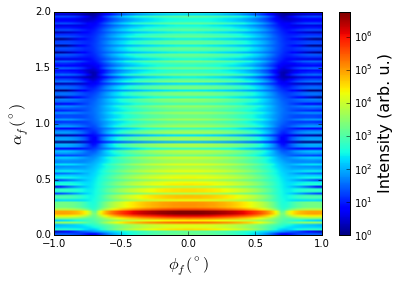

In [28]:
result = run_simulation3()
plot_intensity_data(result)